===================================================
## **Customer Lifetime Value Prediction**
===================================================

Customer Lifetime Value (CLV),  refers to the total predicted revenue that a business can expect to earn from a customer throughout their entire relationship. It is a key metric in marketing and customer relationship management that helps businesses understand the long-term value of acquiring and retaining a customer.

Calculating CLV involves considering factors such as the customer's average purchase value, purchase frequency, and the expected duration of the customer's relationship with the business. By understanding the lifetime value of a customer, businesses can make informed decisions about resource allocation, customer retention efforts, and the overall focus of their marketing strategies.

In this notebook we will calculate CLV for each customer based on the customer transaction information. Then we will create a classes based on CLV  then train a classification model to predict CLV class. 

**Import required libraries**

In [43]:
import pandas as pd 
import numpy as np 
import joblib
import pickle
import matplotlib.pyplot as plt 
plt.style.use('ggplot')
import seaborn as sns 


from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import  RobustScaler ,StandardScaler
from sklearn.metrics import  confusion_matrix, classification_report, precision_score, recall_score, f1_score, accuracy_score
from sklearn.linear_model import  LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import  DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier


import warnings
warnings.filterwarnings('ignore')

**Read the saved data**

In [44]:
# read 
rfm_df = pd.read_csv('customer_rfm_data.csv')
rfm_df.head()

,customer_id,recency,frequency,monetary_value
0,12346,108,1,174.98174
1,12347,60,31,12090.29580
2,12348,74,8,1501.92620
3,12350,18,11,1183.71394
4,12356,108,13,1753.45086


In [45]:
# cleaned and pre-processed online sales data with customer information.
sales_df = pd.read_csv('online_sales_final.csv')
sales_df.head()

,customer_id,transaction_id,transaction_date,product_sku,product_description,product_category,quantity,avg_price,delivery_charges,coupon_status,month,gender,location,tenure_months,gst,coupon_code,discount_pct,invoice_value,first_purchase_date,customer_type
0,17850,16679,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.5,Used,Jan,M,Chicago,12,0.10,ELEC10,0.1,158.6729,2019-01-01,New
1,17850,16680,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.5,Used,Jan,M,Chicago,12,0.10,ELEC10,0.1,158.6729,2019-01-01,New
2,17850,16681,2019-01-01,GGOEGFKQ020399,Google Laptop and Cell Phone Stickers,Office,1,2.05,6.5,Used,Jan,M,Chicago,12,0.10,OFF10,0.1,8.5295,2019-01-01,New
3,17850,16682,2019-01-01,GGOEGAAB010516,Google Men's 100% Cotton Short Sleeve Hero Tee...,Apparel,5,17.53,6.5,Not Used,Jan,M,Chicago,12,0.18,SALE10,0.1,99.5843,2019-01-01,New
4,17850,16682,2019-01-01,GGOEGBJL013999,Google Canvas Tote Natural/Navy,Bags,1,16.50,6.5,Used,Jan,M,Chicago,12,0.18,AIO10,0.1,24.0230,2019-01-01,New


In [46]:
#  convert 'transaction_date' to datetime format 1
sales_df['transaction_date'] = pd.to_datetime(sales_df['transaction_date'])

In [47]:
# create discount_amount feature 
sales_df['discount_amount'] = sales_df['avg_price'] * sales_df['quantity'] * (sales_df['discount_pct'])

**Create Customer level aggregate data**

In [48]:
# custom function to calculate mode 
def calculate_mode(col):
    unique_elements, counts = np.unique(col, return_counts=True)
    max_count_index = np.argmax(counts)
    return unique_elements[max_count_index]

# lambda function to calculate coupen usage rate 
coupen_usage = lambda x: (x=='Used').mean()

In [49]:
# customer level aggregate 
customer_data = sales_df.groupby('customer_id').agg(
    favourite_category = ('product_category', calculate_mode),
    discount_per_order = ('discount_amount', 'mean'),
    avg_basket_size = ('quantity', 'mean'),
    coupen_usage_rate = ('coupon_status', lambda x: coupen_usage(x)),
    tenure_months = ('tenure_months', 'max'),
    gender = ('gender', 'first'),
    location = ('location', 'first'), 
).reset_index()

In [50]:
# merge rfm data of customers 
customer_data = pd.merge(customer_data, rfm_df, on='customer_id')
customer_data.head()

,customer_id,favourite_category,discount_per_order,avg_basket_size,coupen_usage_rate,tenure_months,gender,location,recency,frequency,monetary_value
0,12346,Apparel,4.648500,1.500000,1.000000,31,F,New York,108,1,174.98174
1,12347,Nest-USA,64.697850,5.700000,0.333333,20,M,New York,60,31,12090.29580
2,12348,Office,13.026870,9.086957,0.478261,39,M,California,74,8,1501.92620
3,12350,Apparel,24.001235,1.235294,0.352941,25,M,California,18,11,1183.71394
4,12356,Apparel,12.020583,1.555556,0.305556,31,F,Chicago,108,13,1753.45086


In [51]:
# average order value 
customer_data['avg_order_value'] = customer_data['monetary_value'] / customer_data['frequency']
# purchase frequency 
customer_data['purchase_frequency'] = customer_data['frequency'] / len(customer_data)

# retention rate 
repeat_customers = customer_data [customer_data['frequency'] > 1 ]
retention_rate  = len(repeat_customers) / len(customer_data)

# churn rate 
churn_rate = round(( 1 - retention_rate), 2)

# display the result 
print(f"Customer Retention Rate : {retention_rate*100:.2f} %")
print(f"Customer Churn Rate: {churn_rate*100:0.2f} %")


Customer Retention Rate : 91.49 %
Customer Churn Rate: 9.00 %


**We calculate customer lifetime value (CLV) using the formula below using the avaialable data.**

In [52]:
# calcualte lifetime value
customer_data['lifetime_value'] = customer_data['avg_order_value'] * customer_data['purchase_frequency'] * customer_data['tenure_months'] * retention_rate
customer_data.head()

,customer_id,favourite_category,discount_per_order,avg_basket_size,coupen_usage_rate,tenure_months,gender,location,recency,frequency,monetary_value,avg_order_value,purchase_frequency,lifetime_value
0,12346,Apparel,4.648500,1.500000,1.000000,31,F,New York,108,1,174.98174,174.981740,0.000681,3.380480
1,12347,Nest-USA,64.697850,5.700000,0.333333,20,M,New York,60,31,12090.29580,390.009542,0.021117,150.692217
2,12348,Office,13.026870,9.086957,0.478261,39,M,California,74,8,1501.92620,187.740775,0.005450,36.503718
3,12350,Apparel,24.001235,1.235294,0.352941,25,M,California,18,11,1183.71394,107.610358,0.007493,18.442113
4,12356,Apparel,12.020583,1.555556,0.305556,31,F,Chicago,108,13,1753.45086,134.880835,0.008856,33.874991


In [53]:
# save the dataframe 
customer_data.to_csv('customer_sales_data.csv', index_label=False)

In [54]:
# create customer ranks based on lifetime value.
customer_data['clv_rank'] = customer_data['lifetime_value'].rank(ascending=False)
customer_data.head()

,customer_id,favourite_category,discount_per_order,avg_basket_size,coupen_usage_rate,tenure_months,gender,location,recency,frequency,monetary_value,avg_order_value,purchase_frequency,lifetime_value,clv_rank
0,12346,Apparel,4.648500,1.500000,1.000000,31,F,New York,108,1,174.98174,174.981740,0.000681,3.380480,1244.0
1,12347,Nest-USA,64.697850,5.700000,0.333333,20,M,New York,60,31,12090.29580,390.009542,0.021117,150.692217,117.0
2,12348,Office,13.026870,9.086957,0.478261,39,M,California,74,8,1501.92620,187.740775,0.005450,36.503718,544.0
3,12350,Apparel,24.001235,1.235294,0.352941,25,M,California,18,11,1183.71394,107.610358,0.007493,18.442113,828.0
4,12356,Apparel,12.020583,1.555556,0.305556,31,F,Chicago,108,13,1753.45086,134.880835,0.008856,33.874991,573.0


In [55]:
# sort the data according to increasing order of ranking.
clv_sorted = customer_data.sort_values('clv_rank', ascending=True)
clv_sorted.head()

,customer_id,favourite_category,discount_per_order,avg_basket_size,coupen_usage_rate,tenure_months,gender,location,recency,frequency,monetary_value,avg_order_value,purchase_frequency,lifetime_value,clv_rank
736,15311,Apparel,20.792509,7.173765,0.321976,40,F,Chicago,13,291,76540.74430,263.026613,0.198229,1907.992108,1.0
118,12748,Apparel,17.175587,7.005755,0.362590,28,F,Chicago,108,328,78753.89421,240.103336,0.223433,1374.212741,2.0
563,14606,Apparel,22.112017,5.438261,0.380870,33,F,Chicago,1,289,56727.87067,196.290210,0.196866,1166.633179,3.0
643,14911,Apparel,16.839287,4.267686,0.340344,34,F,California,11,276,51725.14647,187.409951,0.188011,1095.984842,4.0
1218,17337,Apparel,41.047454,5.569231,0.311538,44,F,California,17,139,30141.51379,216.845423,0.094687,826.497678,5.0


Define customer classes based on `clv_rank`
- Top 30 % of customers are `High-Value` customers 
- Next 40 % of customers are `Medium-Value`
- Bottom 30 % customers are `Low-Value`

In [56]:
# Calculate the number of customers in each tier
total_customers = len(customer_data)
tier_sizes = {
    'high_value': int(0.3 * total_customers),
    'med_value': int(0.4 * total_customers),
    'low_value': int(0.3 * total_customers),
}

# Calculate cumulative tier sizes
cumulative_sizes = [0] + list(tier_sizes.values())
cumulative_sizes = [sum(cumulative_sizes[:i+1]) for i in range(len(cumulative_sizes))]
cumulative_sizes[-1] = total_customers + 1  # Set the last element to total_customers

# Create bin edges based on the cumulative tier sizes
bin_edges = cumulative_sizes

# Create a new column 'customer_tier' based on the adjusted bin edges
clv_sorted['clv_category'] = pd.cut(
    clv_sorted['clv_rank'],
    bins=bin_edges,
    labels=['High_Value', 'Medium_Value', 'Low_Value'],
    include_lowest=True,
    right=False
)
clv_sorted.head(10)

,customer_id,favourite_category,discount_per_order,avg_basket_size,coupen_usage_rate,tenure_months,gender,location,recency,frequency,monetary_value,avg_order_value,purchase_frequency,lifetime_value,clv_rank,clv_category
736,15311,Apparel,20.792509,7.173765,0.321976,40,F,Chicago,13,291,76540.74430,263.026613,0.198229,1907.992108,1.0,High_Value
118,12748,Apparel,17.175587,7.005755,0.362590,28,F,Chicago,108,328,78753.89421,240.103336,0.223433,1374.212741,2.0,High_Value
563,14606,Apparel,22.112017,5.438261,0.380870,33,F,Chicago,1,289,56727.87067,196.290210,0.196866,1166.633179,3.0,High_Value
643,14911,Apparel,16.839287,4.267686,0.340344,34,F,California,11,276,51725.14647,187.409951,0.188011,1095.984842,4.0,High_Value
1218,17337,Apparel,41.047454,5.569231,0.311538,44,F,California,17,139,30141.51379,216.845423,0.094687,826.497678,5.0,High_Value
1355,17841,Apparel,14.998423,4.590909,0.363636,21,M,California,18,263,49397.24444,187.822222,0.179155,646.466343,6.0,High_Value
572,14646,Apparel,12.239193,2.693103,0.344828,45,M,California,91,114,21208.30836,186.037793,0.077657,594.760947,7.0,High_Value
214,13113,Nest-USA,40.563113,40.225806,0.258065,44,M,New Jersey,8,29,20767.64901,716.125828,0.019755,569.460904,8.0,High_Value
578,14667,Apparel,19.660310,9.363095,0.351190,30,F,California,111,71,27306.44745,384.597851,0.048365,510.517176,9.0,High_Value
806,15601,Apparel,18.276643,10.528662,0.375796,46,F,Chicago,48,88,17398.62501,197.711648,0.059946,498.765794,10.0,High_Value


In [57]:
# merge clv_classes  with customer data 
customer_data = pd.merge(customer_data, clv_sorted[['customer_id', 'clv_category']], on='customer_id')
customer_data.head()

,customer_id,favourite_category,discount_per_order,avg_basket_size,coupen_usage_rate,tenure_months,gender,location,recency,frequency,monetary_value,avg_order_value,purchase_frequency,lifetime_value,clv_rank,clv_category
0,12346,Apparel,4.648500,1.500000,1.000000,31,F,New York,108,1,174.98174,174.981740,0.000681,3.380480,1244.0,Low_Value
1,12347,Nest-USA,64.697850,5.700000,0.333333,20,M,New York,60,31,12090.29580,390.009542,0.021117,150.692217,117.0,High_Value
2,12348,Office,13.026870,9.086957,0.478261,39,M,California,74,8,1501.92620,187.740775,0.005450,36.503718,544.0,Medium_Value
3,12350,Apparel,24.001235,1.235294,0.352941,25,M,California,18,11,1183.71394,107.610358,0.007493,18.442113,828.0,Medium_Value
4,12356,Apparel,12.020583,1.555556,0.305556,31,F,Chicago,108,13,1753.45086,134.880835,0.008856,33.874991,573.0,Medium_Value


In [58]:
# drop redundant features 
customer_data.drop(['clv_rank', 'lifetime_value'], axis=1, inplace=True)

### **Exploratory Data Analysis**

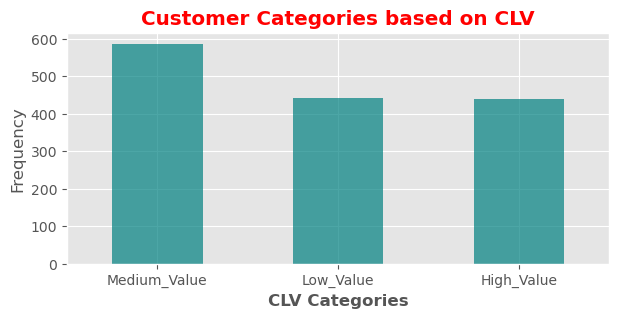

In [59]:
# category distribution 
clv_category_counts = customer_data['clv_category'].value_counts()
# Plotting
plt.figure(figsize=(7, 3))
clv_category_counts.plot(kind='bar', color='teal', alpha=0.7)
plt.title('Customer Categories based on CLV', weight='bold', color='r')
plt.xlabel('CLV Categories', weight='bold')
plt.ylabel('Frequency')
plt.xticks(rotation=0) 
plt.show()

**Customer Categories by Location** 

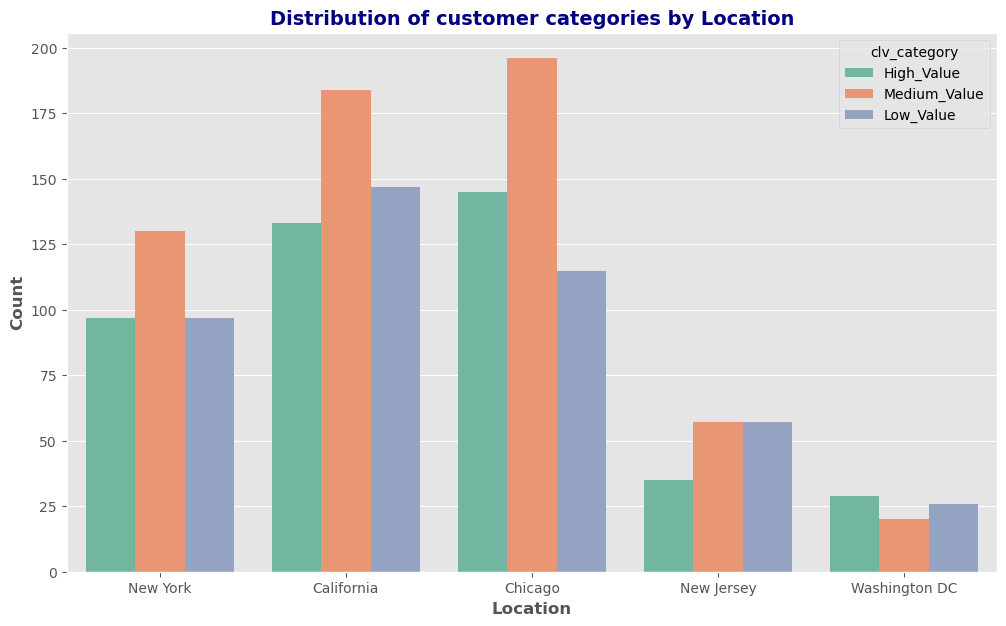

In [60]:
# count plot 
plt.figure(figsize=(12, 7))
sns.countplot(x='location', data=customer_data,  hue='clv_category', palette='Set2')
plt.title('Distribution of customer categories by Location', weight='bold', color='#000080', fontsize=14)
plt.xlabel('Location', weight='bold')
plt.ylabel('Count', weight='bold')
plt.show()

**Customer categories by Gender**

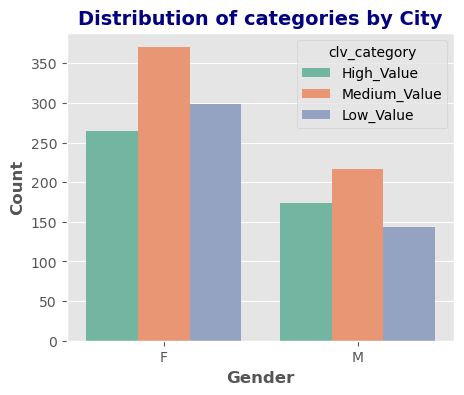

In [61]:
# count plot of location by cluster
plt.figure(figsize=(5 , 4))
sns.countplot(x='gender', data=customer_data,  hue='clv_category', palette='Set2')
plt.title('Distribution of categories by City', weight='bold', color='#000080', fontsize=14)
plt.xlabel('Gender', weight='bold')
plt.ylabel('Count', weight='bold')
plt.show()

**Customer categories by favourite Product**

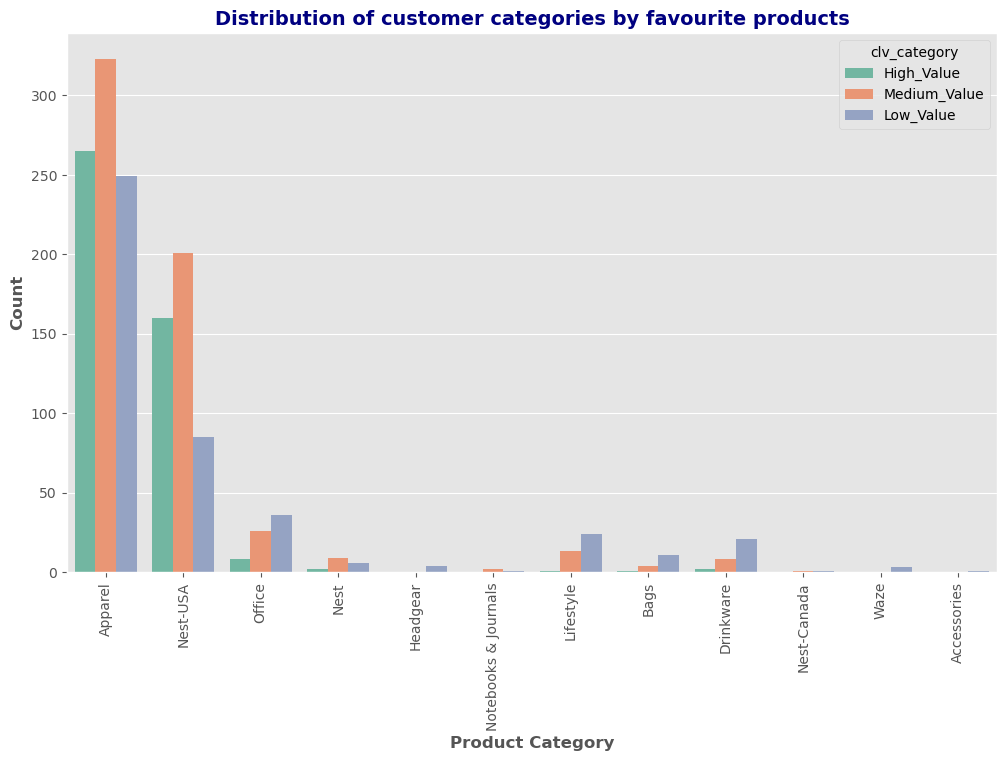

In [62]:
# count plot of location by cluster
plt.figure(figsize=(12, 7))
sns.countplot(x='favourite_category', data=customer_data,  hue='clv_category', palette='Set2')
plt.title('Distribution of customer categories by favourite products', weight='bold', color='#000080', fontsize=14)
plt.xlabel('Product Category', weight='bold')
plt.ylabel('Count', weight='bold')
plt.xticks(rotation=90)
plt.show()

Analyse numerical features and their relation with CLV classes. 

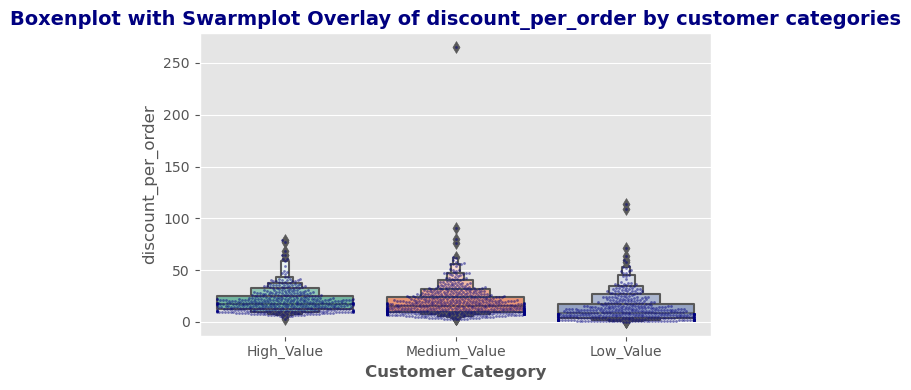

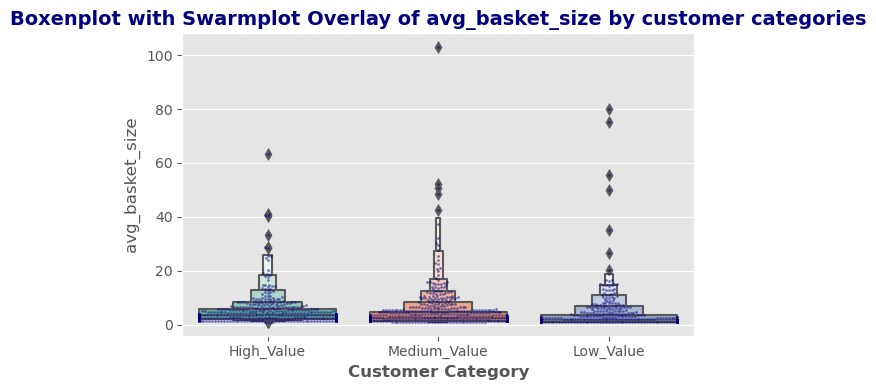

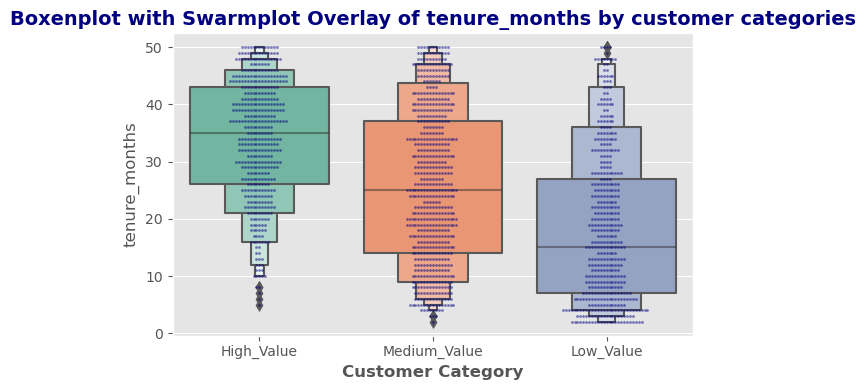

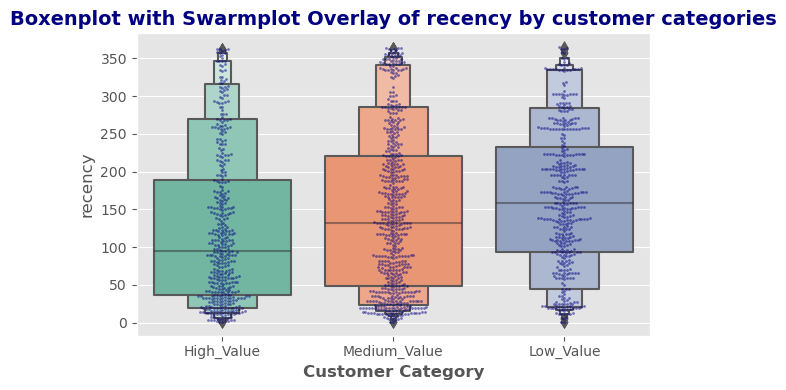

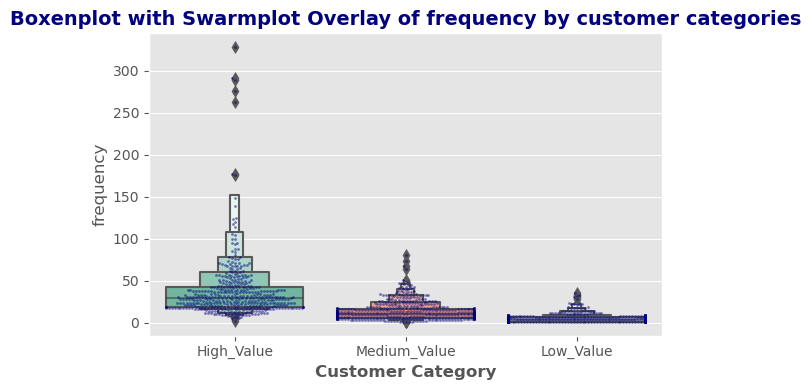

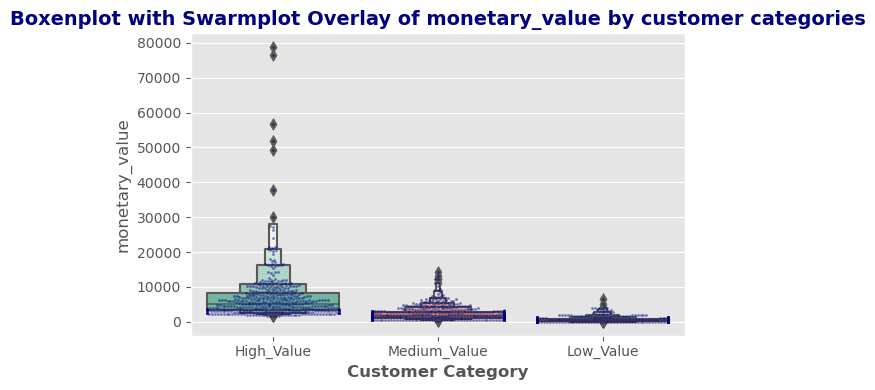

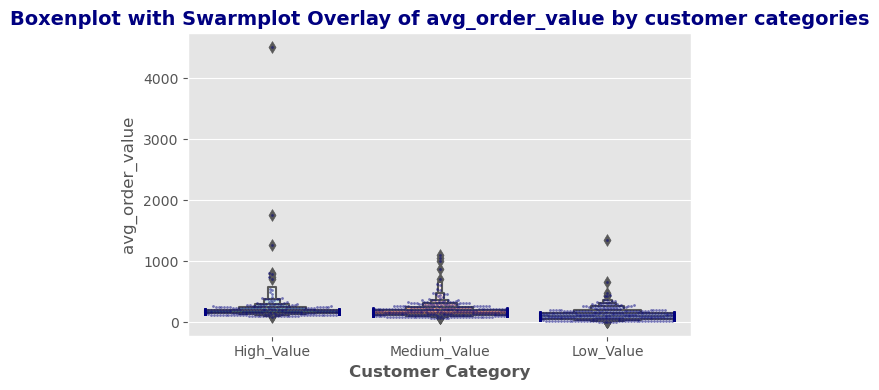

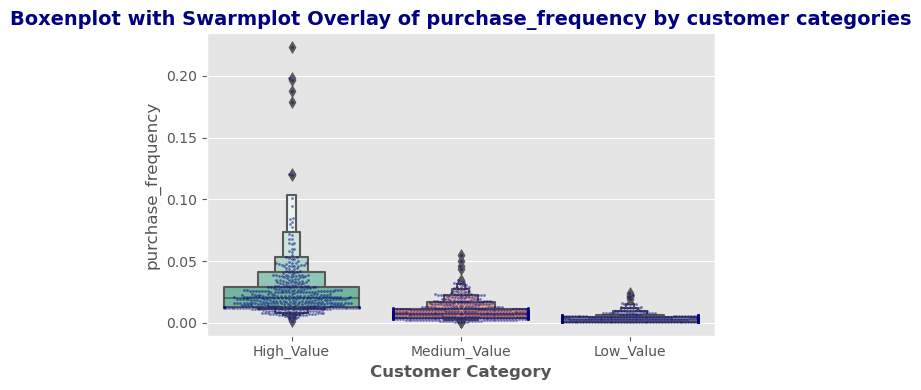

In [63]:
features_to_analyze = ['discount_per_order', 'avg_basket_size', 'tenure_months', 'recency', 'frequency', 'monetary_value', 'avg_order_value', 'purchase_frequency']

for feature in features_to_analyze:

    # Create a boxenplot with swarmplot overlay
    plt.figure(figsize=(6, 4))
    sns.boxenplot(x='clv_category', y=feature, data=customer_data, palette='Set2')
    sns.swarmplot(x='clv_category', y=feature, data=customer_data, color='#000080', size=2, alpha=0.5)  # Overlay swarmplot
    plt.title(f"Boxenplot with Swarmplot Overlay of {feature} by customer categories", weight='bold', color='#000080', fontsize=14)
    plt.xlabel('Customer Category', weight='bold')
    plt.tight_layout()
    plt.show()

In [64]:
# drop redundant column for model training 
customer_data.drop(['customer_id', 'favourite_category', 'purchase_frequency'] , axis=1, inplace=True)
customer_data.head()

,discount_per_order,avg_basket_size,coupen_usage_rate,tenure_months,gender,location,recency,frequency,monetary_value,avg_order_value,clv_category
0,4.648500,1.500000,1.000000,31,F,New York,108,1,174.98174,174.981740,Low_Value
1,64.697850,5.700000,0.333333,20,M,New York,60,31,12090.29580,390.009542,High_Value
2,13.026870,9.086957,0.478261,39,M,California,74,8,1501.92620,187.740775,Medium_Value
3,24.001235,1.235294,0.352941,25,M,California,18,11,1183.71394,107.610358,Medium_Value
4,12.020583,1.555556,0.305556,31,F,Chicago,108,13,1753.45086,134.880835,Medium_Value


In [65]:
# encoding nominal features
customer_data = pd.get_dummies(customer_data, columns=['gender', 'location'], drop_first=True)
customer_data.head()


,discount_per_order,avg_basket_size,coupen_usage_rate,tenure_months,recency,frequency,monetary_value,avg_order_value,clv_category,gender_M,location_Chicago,location_New Jersey,location_New York,location_Washington DC
0,4.648500,1.500000,1.000000,31,108,1,174.98174,174.981740,Low_Value,0,0,0,1,0
1,64.697850,5.700000,0.333333,20,60,31,12090.29580,390.009542,High_Value,1,0,0,1,0
2,13.026870,9.086957,0.478261,39,74,8,1501.92620,187.740775,Medium_Value,1,0,0,0,0
3,24.001235,1.235294,0.352941,25,18,11,1183.71394,107.610358,Medium_Value,1,0,0,0,0
4,12.020583,1.555556,0.305556,31,108,13,1753.45086,134.880835,Medium_Value,0,1,0,0,0


**Encoding Target classes** 

In [66]:
# encode target for model training 
category_map = {
    'High_Value': 0 ,
    'Medium_Value': 1,
    'Low_Value': 2
    }
customer_data['clv_category_enc'] = customer_data['clv_category'].map(category_map)

print(customer_data[['clv_category', 'clv_category_enc']].head())

   clv_category clv_category_enc
0     Low_Value                2
1    High_Value                0
2  Medium_Value                1
3  Medium_Value                1
4  Medium_Value                1


In [ ]:
# drop clv_category 
customer_data.drop('clv_category', axis=1, inplace=True)

**Train-Test Splitting**

In [70]:
# split train and test data 
X_train, X_test, y_train, y_test = train_test_split(customer_data.drop('clv_category_enc', axis=1), customer_data['clv_category_enc'], test_size=0.2, random_state=42)

X_train.shape, X_test.shape

((1174, 13), (294, 13))

**Feature scaling**

In [71]:
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### **Model Selection**

Model: LogisticRegression
Accuracy: 0.8299
Precision: 0.8297
Recall: 0.8299
F1 Score: 0.8298


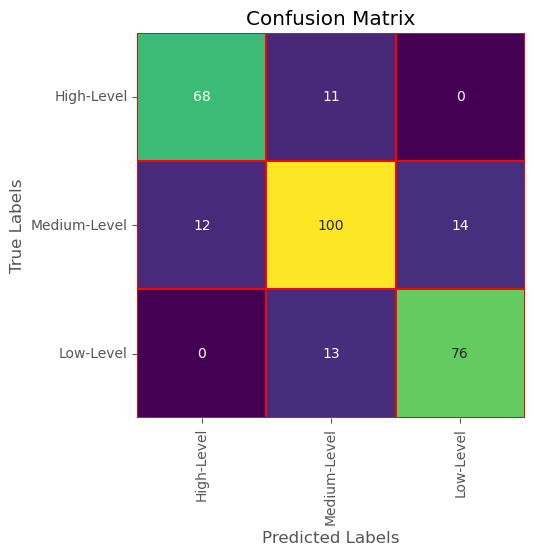

Model: GuassianNB
Accuracy: 0.6973
Precision: 0.7055
Recall: 0.6973
F1 Score: 0.6919


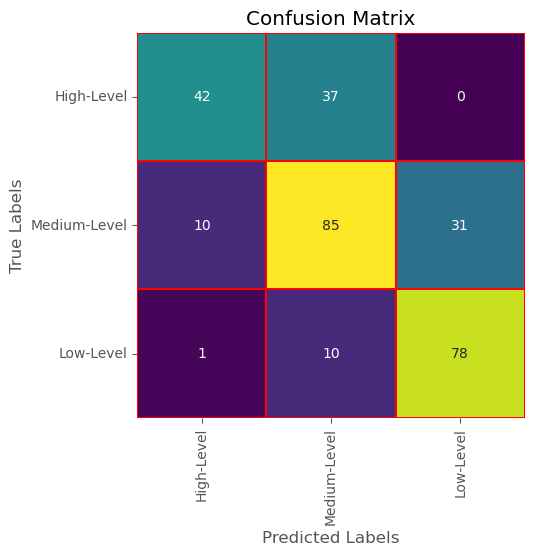

Model: Decision Tree
Accuracy: 0.9558
Precision: 0.9562
Recall: 0.9558
F1 Score: 0.9559


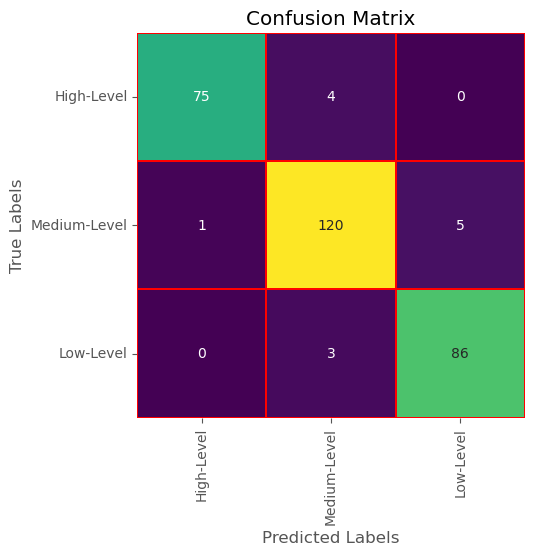

Model: Random Forest
Accuracy: 0.9320
Precision: 0.9356
Recall: 0.9320
F1 Score: 0.9322


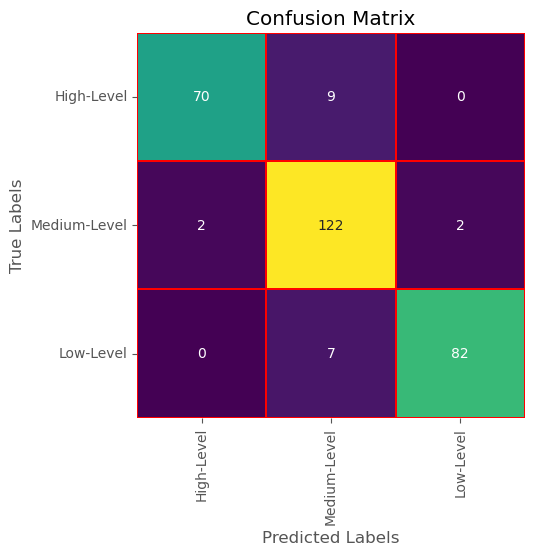

Model: ExtraTreeClassifier
Accuracy: 0.6939
Precision: 0.6962
Recall: 0.6939
F1 Score: 0.6945


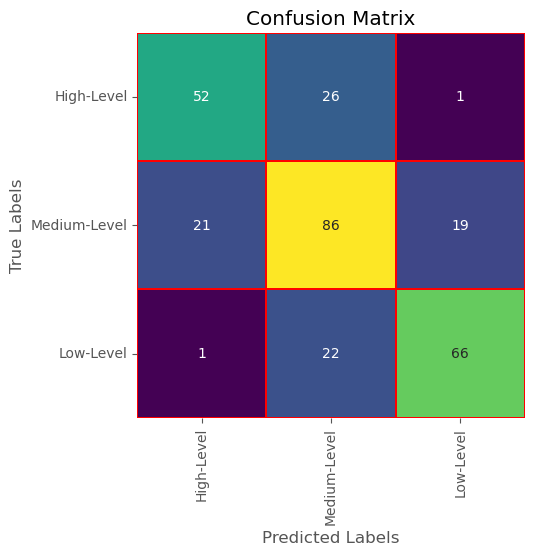

Model: XGBoost
Accuracy: 0.9694
Precision: 0.9700
Recall: 0.9694
F1 Score: 0.9695


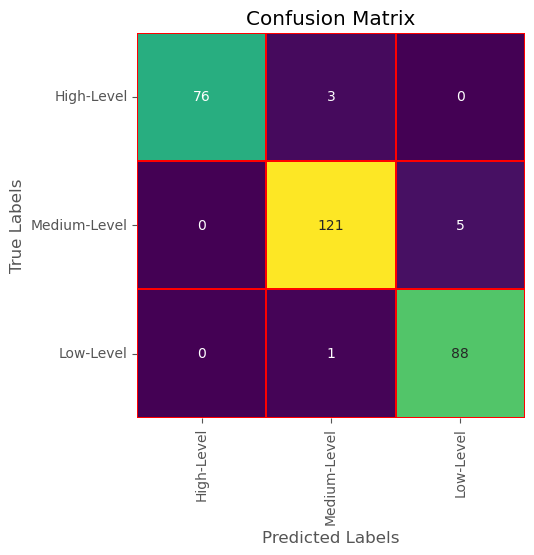

In [72]:
models = {
    "LogisticRegression" : LogisticRegression(),
    "GuassianNB": GaussianNB(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "ExtraTreeClassifier": ExtraTreeClassifier(),
    "XGBoost": XGBClassifier(),
}

# Train and evaluate each model
for model_name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    
    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    # Print the evaluation metrics for each model
    print(f"Model: {model_name}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    # calcualte confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    # Mapping of classes to their corresponding names
    class_names = ['High-Level', 'Medium-Level', 'Low-Level']
    # Display the confusion matrix with centered ticks
    plt.figure(figsize=(5, 5))
    ax = sns.heatmap(cm, annot=True, fmt="d", linewidths=0.3, linecolor='red', cmap='viridis', cbar=False)

    # Set the ticks at the center of each square
    ax.set_xticks(np.arange(len(class_names)) + 0.5, minor=False)
    ax.set_yticks(np.arange(len(class_names)) + 0.5, minor=False)

    # Set the tick labels
    ax.set_xticklabels(class_names, rotation=90)
    ax.set_yticklabels(class_names, rotation=0)

    # Set labels and title
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()
    print("===" * 20)


### **Model Training**

Model: XGBoost
Accuracy: 0.9694
Precision: 0.9700
Recall: 0.9694
F1 Score: 0.9695


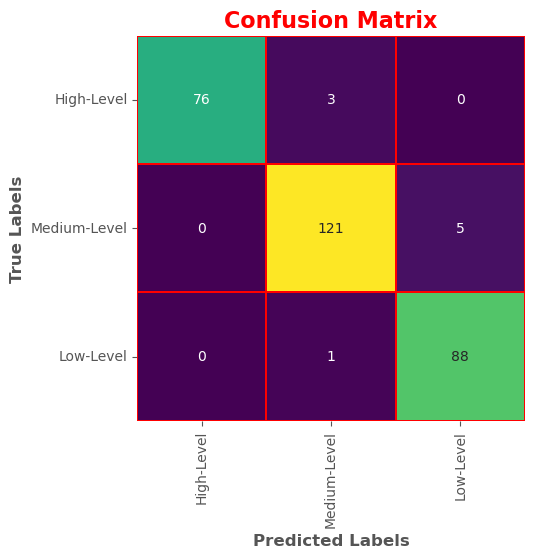

In [73]:
xgb_clf = XGBClassifier()
xgb_clf.fit(X_train, y_train)

y_pred = xgb_clf.predict(X_test)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Print the evaluation metrics for each model
print(f"Model: {model_name}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# calcualte confusion matrix
cm = confusion_matrix(y_test, y_pred)
# Mapping of classes to their corresponding names
class_names = ['High-Level', 'Medium-Level', 'Low-Level']
# Display the confusion matrix with centered ticks
plt.figure(figsize=(5, 5))
ax = sns.heatmap(cm, annot=True, fmt="d", linewidths=0.3, linecolor='red', cmap='viridis', cbar=False)

# Set the ticks at the center of each square
ax.set_xticks(np.arange(len(class_names)) + 0.5, minor=False)
ax.set_yticks(np.arange(len(class_names)) + 0.5, minor=False)

# Set the tick labels
ax.set_xticklabels(class_names, rotation=90)
ax.set_yticklabels(class_names, rotation=0)

# Set labels and title
plt.xlabel('Predicted Labels' , weight='bold')
plt.ylabel('True Labels', weight='bold')
plt.title('Confusion Matrix', weight='bold', fontsize=16, color='r')
plt.show()
print("===" * 20)

**Hyper Parameter Tuning**

Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 50, 'scale_pos_weight': 1}
Accuracy: 0.9694
Precision: 0.9700
Recall: 0.9694
F1 Score: 0.9695


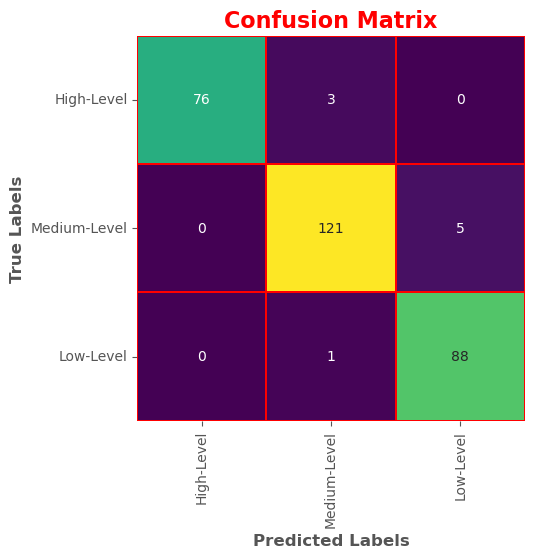

In [74]:
# Define the parameter grid to search
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 200],
    'max_depth': [7, 9, 12],
    'min_child_weight': [1, 3, 5],
    'scale_pos_weight': [1, 2, 3]
}

# Create an XGBoost classifier
xgb_clf = XGBClassifier()

# Create a GridSearchCV object
grid_search = GridSearchCV(estimator=xgb_clf, param_grid=param_grid, scoring='accuracy', cv=5, n_jobs=-1)

# Fit the GridSearchCV object to the data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_

# Get the best model
best_model = grid_search.best_estimator_

# Make predictions on the test set with the best model
y_pred_best = best_model.predict(X_test)

# Evaluate the best model
# Calculate evaluation metrics
accuracy_best = accuracy_score(y_test, y_pred)
precision_best = precision_score(y_test, y_pred, average='weighted')
recall_best = recall_score(y_test, y_pred, average='weighted')
f1_best = f1_score(y_test, y_pred, average='weighted')

# Print the results
print("Best Hyperparameters:", best_params)

# Print the evaluation metrics for each model
print(f"Accuracy: {accuracy_best:.4f}")
print(f"Precision: {precision_best:.4f}")
print(f"Recall: {recall_best:.4f}")
print(f"F1 Score: {f1_best:.4f}")

# calcualte confusion matrix
cm = confusion_matrix(y_test, y_pred)
# Mapping of classes to their corresponding names
class_names = ['High-Level', 'Medium-Level', 'Low-Level']
# Display the confusion matrix with centered ticks
plt.figure(figsize=(5, 5))
ax = sns.heatmap(cm, annot=True, fmt="d", linewidths=0.3, linecolor='red', cmap='viridis', cbar=False)

# Set the ticks at the center of each square
ax.set_xticks(np.arange(len(class_names)) + 0.5, minor=False)
ax.set_yticks(np.arange(len(class_names)) + 0.5, minor=False)

# Set the tick labels
ax.set_xticklabels(class_names, rotation=90)
ax.set_yticklabels(class_names, rotation=0)

# Set labels and title
plt.xlabel('Predicted Labels' , weight='bold')
plt.ylabel('True Labels', weight='bold')
plt.title('Confusion Matrix', weight='bold', fontsize=16, color='r')
plt.show()
print("===" * 20)

In [75]:
# save the model as pickle
model_filename = 'CLV_category_classification.pkl'
joblib.dump('xgb_clf', model_filename)

['CLV_category_classification.pkl']